<a href="https://colab.research.google.com/github/MasaAsami/LTsandox/blob/main/notebooks/%E8%B3%83%E9%87%91%E6%A7%8B%E9%80%A0%E5%9F%BA%E6%9C%AC%E8%AA%BF%E6%9F%BB%E3%82%B5%E3%83%B3%E3%83%97%E3%83%AB%E5%88%86%E6%9E%90_%E6%89%80%E5%AE%9A%E5%86%85%E7%B5%A6%E4%B8%8E%E4%BB%A5%E5%A4%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 賃金構造基本調査
- 「所定内給与」以外のデータも同時に抜く方法
- 今回は全てのカラムを取得するコードを紹介します
- assertionも忘れずに

In [1]:
# @title パラメータ
_URL = "https://www.e-stat.go.jp/"

after_path_dict = {
    "2020": {
        "正社員・正職員計": "/stat-search/file-download?statInfId=000032069456&fileKind=0",
        "正社員・正職員以外計": "/stat-search/file-download?statInfId=000032069457&fileKind=0",
    },
    "2021": {
        "正社員・正職員計": "/stat-search/file-download?statInfId=000032182977&fileKind=4",
        "正社員・正職員以外計": "/stat-search/file-download?statInfId=000032182978&fileKind=4",
    },
}
before_path_dict = {
    "2009_正社員・正職員計": "/stat-search/file-download?statInfId=000032135133&fileKind=4",
    "2008_正社員・正職員計": "/stat-search/file-download?statInfId=000032135195&fileKind=4",
    "2007_正社員・正職員計": "/stat-search/file-download?statInfId=000032135257&fileKind=4",
    "2006_正社員・正職員計": "/stat-search/file-download?statInfId=000032135319&fileKind=4",
    "2019_正社員・正職員計": "/stat-search/file-download?statInfId=000032117087&fileKind=4",
    "2018_正社員・正職員計": "/stat-search/file-download?statInfId=000032117103&fileKind=4",
    "2017_正社員・正職員計": "/stat-search/file-download?statInfId=000032117119&fileKind=4",
    "2016_正社員・正職員計": "/stat-search/file-download?statInfId=000032117135&fileKind=4",
    "2015_正社員・正職員計": "/stat-search/file-download?statInfId=000032117151&fileKind=4",
    "2014_正社員・正職員計": "/stat-search/file-download?statInfId=000032117167&fileKind=4",
    "2013_正社員・正職員計": "/stat-search/file-download?statInfId=000032117183&fileKind=4",
    "2012_正社員・正職員計": "/stat-search/file-download?statInfId=000032117199&fileKind=4",
    "2011_正社員・正職員計": "/stat-search/file-download?statInfId=000032117215&fileKind=4",
    "2010_正社員・正職員計": "/stat-search/file-download?statInfId=000032117231&fileKind=4",
    "2009_正社員・正職員以外計": "/stat-search/file-download?statInfId=000032135134&fileKind=4",
    "2008_正社員・正職員以外計": "/stat-search/file-download?statInfId=000032135196&fileKind=4",
    "2007_正社員・正職員以外計": "/stat-search/file-download?statInfId=000032135258&fileKind=4",
    "2006_正社員・正職員以外計": "/stat-search/file-download?statInfId=000032135320&fileKind=4",
    "2019_正社員・正職員以外計": "/stat-search/file-download?statInfId=000032117088&fileKind=4",
    "2018_正社員・正職員以外計": "/stat-search/file-download?statInfId=000032117104&fileKind=4",
    "2017_正社員・正職員以外計": "/stat-search/file-download?statInfId=000032117120&fileKind=4",
    "2016_正社員・正職員以外計": "/stat-search/file-download?statInfId=000032117136&fileKind=4",
    "2015_正社員・正職員以外計": "/stat-search/file-download?statInfId=000032117152&fileKind=4",
    "2014_正社員・正職員以外計": "/stat-search/file-download?statInfId=000032117168&fileKind=4",
    "2013_正社員・正職員以外計": "/stat-search/file-download?statInfId=000032117184&fileKind=4",
    "2012_正社員・正職員以外計": "/stat-search/file-download?statInfId=000032117200&fileKind=4",
    "2011_正社員・正職員以外計": "/stat-search/file-download?statInfId=000032117216&fileKind=4",
    "2010_正社員・正職員以外計": "/stat-search/file-download?statInfId=000032117232&fileKind=4",
}

In [2]:
!pip install -q japanize-matplotlib

In [3]:
import datetime
import time
from IPython.display import display, Markdown

import pandas as pd
from pandas_datareader.stooq import StooqDailyReader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as ticker

import japanize_matplotlib

japanize_matplotlib.japanize()
plt.style.use("ggplot")

In [4]:
# @title 2020年以降の所定内給与額
after2020_df = []
_use_cols = "C:AI"  # 取得すべきカラムを増やす
col_name_list = []  # カラム名にブレがないか事後的に検証する

for _yyyy in after_path_dict.keys():
    for _job_type in after_path_dict[_yyyy].keys():
        print(f"{_yyyy}年 {_job_type} 取得中 :", _URL + after_path_dict[_yyyy][_job_type])
        input_file = pd.ExcelFile(_URL + after_path_dict[_yyyy][_job_type])
        industry_names = input_file.sheet_names
        for _industry in industry_names:
            # まずカラム名を取得する
            temp_df = input_file.parse(
                                _industry,
                                skiprows=7,
                                usecols=_use_cols,
                            )
            temp_df = temp_df.loc[0:2].T
            temp_df[0] = temp_df[0].fillna(method='ffill').fillna("temp_category")
            temp_df[1] = temp_df[1].str.replace("\n", "").fillna("所定内給与額")
            col_names = temp_df.apply(lambda x : str(x[0]) + "_" +  str(x[1])  if x[0] != "temp_category" else "temp_category", axis=1).to_list()
            col_name_list.append(col_names)

            _df = input_file.parse(
                _industry,
                skiprows=11,
                usecols=_use_cols,  
                # 取得すべきカラムの名前も増やす
                names=col_names,
            )
            assert (
                _df.tail(1)["temp_category"].values[0] == "７０歳～"
            ), "assertion error : 最後の行が不正です。確認してください"

            _df = _df.assign(
                gender=_df["temp_category"]
                .apply(
                    lambda x: str(x).split("\n")[0] if str(x).find("\n") > 0 else np.nan
                )
                .fillna(method="ffill"),
                education=_df["temp_category"]
                .apply(
                    lambda x: str(x).split("\n")[1]
                    if str(x).find("\n") > 0
                    else (str(x) if str(x).find("歳") < 0 else np.nan)
                )
                .fillna(method="ffill"),
                age=np.where(
                    _df["temp_category"].str.contains("歳"), _df["temp_category"], "年齢計"
                ),
            ).drop(columns="temp_category")

            _df = pd.melt(
                _df,
                id_vars=["age", "education", "gender"],
                value_name="value",
                var_name="corporate_scale",
                col_level=None,
            )

            _df = _df.assign(
                year=_yyyy,
                industry=_industry,
                unit=_df["corporate_scale"].apply(lambda x : str(x).split("_")[1]),  # corporate scaleからunit名を取り出す
                corporate_scale=_df["corporate_scale"].apply(lambda x : str(x).split("_")[0]),  # corporate scaleからunit名を取り除く
                job_type=_job_type,
                original_url=_URL + after_path_dict[_yyyy][_job_type],
            )

            after2020_df.append(_df)


after2020_df = pd.concat(after2020_df).reset_index(drop=True)

2020年 正社員・正職員計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032069456&fileKind=0
2020年 正社員・正職員以外計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032069457&fileKind=0
2021年 正社員・正職員計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032182977&fileKind=4
2021年 正社員・正職員以外計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032182978&fileKind=4


In [5]:
# @title 2019年以前の所定内給与額
before2020_df = []

for yyyy_job_type in before_path_dict.keys():
    _yyyy, _job_type = yyyy_job_type.split("_")

    print(f"{_yyyy}年 {_job_type} 取得中 :", _URL + before_path_dict[yyyy_job_type])
    input_file = pd.ExcelFile(_URL + before_path_dict[yyyy_job_type])
    industry_names = input_file.sheet_names
    for _industry in industry_names:

        # まずカラム名を取得する
        temp_df = input_file.parse(
                            _industry,
                            skiprows=7,
                            usecols=_use_cols,
                        )
        temp_df = temp_df.loc[0:2].T
        temp_df[0] = temp_df[0].fillna(method='ffill').fillna("temp_category")
        temp_df[1] = temp_df[1].str.replace("\n", "").fillna("所定内給与額")
        col_names = temp_df.apply(lambda x : str(x[0]) + "_" +  str(x[1])  if x[0] != "temp_category" else "temp_category", axis=1).to_list()
        col_name_list.append(col_names)

        _df = input_file.parse(
            _industry,
            skiprows=11,
            usecols=_use_cols, 
            names=col_names,
        )
        assert (
            _df.tail(1)["temp_category"].values[0] == "７０歳～"
        ), "assertion error : 最後の行が不正です。確認してください"

        _df = _df.assign(
                gender = _df["temp_category"].apply(lambda x: str(x).replace("　", "").strip().split("\n")[0] if str(x).find("\n")> 0 else np.nan).fillna(method='ffill'),
                education = _df["temp_category"].apply(lambda x: "学歴計" if str(x).find("\n")> 0 else (str(x).replace("　", "").strip() if str(x).find("歳") < 0 else np.nan)).fillna(method='ffill'),
                age = np.where(_df["temp_category"].str.contains("歳"), _df["temp_category"], '年齢計'),
            ).drop(columns='temp_category')

        _df = pd.melt(
                _df, 
                id_vars=["age", "education", "gender"], 
                value_name='value', 
                var_name="corporate_scale",
           )

        _df = _df.assign(
                year=_yyyy,
                industry=_industry,
                unit=_df["corporate_scale"].apply(lambda x : str(x).split("_")[1]),
                corporate_scale=_df["corporate_scale"].apply(lambda x : str(x).split("_")[0]),
                job_type=_job_type,
                original_url=_URL + before_path_dict[yyyy_job_type],
        )

        before2020_df.append(_df)


before2020_df = pd.concat(before2020_df).reset_index(drop=True)

2009年 正社員・正職員計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032135133&fileKind=4
2008年 正社員・正職員計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032135195&fileKind=4
2007年 正社員・正職員計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032135257&fileKind=4
2006年 正社員・正職員計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032135319&fileKind=4
2019年 正社員・正職員計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032117087&fileKind=4
2018年 正社員・正職員計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032117103&fileKind=4
2017年 正社員・正職員計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032117119&fileKind=4
2016年 正社員・正職員計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032117135&fileKind=4
2015年 正社員・正職員計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032117151&fileKind=4
2014年 正社員・正職員計 取得中 : https://www.e-st

In [6]:
assert len(set([str(_cols) for _cols in col_name_list])) == 1, "[assertion error] カラムに表記ブレや位置ズレがある可能性があります"

In [7]:
#@title 少し整形
age_map = {
    "\u3000\u3000～１９歳": "age_00_19_group",
    "２０～２４歳": "age_20_24_group",
    "２５～２９歳": "age_25_29_group",
    "３０～３４歳": "age_30_34_group",
    "３５～３９歳": "age_35_39_group",
    "４０～４４歳": "age_40_44_group",
    "４５～４９歳": "age_45_49_group",
    "５０～５４歳": "age_50_54_group",
    "５５～５９歳": "age_55_59_group",
    "６０～６４歳": "age_60_64_group",
    "６５～６９歳": "age_65_69_group",
    "７０歳～": "age_70over_group",
}


after2020_df = after2020_df.assign(
    industry_code=after2020_df['industry'].apply(lambda x : x[:1] if str(x).find( "産業計") < 0 else x),
    age=after2020_df["age"].replace(
        age_map
    ),
    value=after2020_df["value"].replace("-",np.nan)
)
   

before2020_df = before2020_df.assign(
    industry_code=before2020_df['industry'].apply(lambda x : x[:1] if str(x).find( "産業計") < 0 else x),
    education=before2020_df["education"].replace(
        {
            "中   学   卒": "中学",
            "高   校   卒": "高校",
            "高専・短大卒": "高専・短大",
            "大学・大学院卒": "大学・大学院",
        }
    ),
    gender=before2020_df["gender"].replace(
        {
            "男 女 計": "男女計",
        }
    ),
    age=before2020_df["age"].replace(
        age_map
    ),
    value=before2020_df["value"].replace("-",np.nan)
)

merged_df = pd.concat([before2020_df, after2020_df]).reset_index(drop=True)
merged_df["year"] = merged_df["year"].astype(int)
merged_df.sample(20)

,age,education,gender,corporate_scale,value,year,industry,unit,job_type,original_url,industry_code
576861,age_70over_group,高専・短大,男女計,"1,000人以上",2401.1,2018,Ｏ教育，学習支援業,年間賞与その他特別給与額,正社員・正職員計,https://www.e-stat.go.jp//stat-search/file-dow...,Ｏ
1388176,age_60_64_group,高校,女,"1,000人以上",467.0,2010,Ｉ卸売業，小売業,年間賞与その他特別給与額,正社員・正職員計,https://www.e-stat.go.jp//stat-search/file-dow...,Ｉ
2217746,age_65_69_group,学歴計,男女計,"1,000人以上",423.1,2016,Ｌ学術研究，専門・技術サービス業,所定内給与額,正社員・正職員以外計,https://www.e-stat.go.jp//stat-search/file-dow...,Ｌ
327435,age_30_34_group,高校,男女計,"1,000人以上",541.0,2006,Ｈ情報通信業,労働者数,正社員・正職員計,https://www.e-stat.go.jp//stat-search/file-dow...,Ｈ
3222884,age_20_24_group,高校,女,10～99人,3.2,2020,Ｑ複合サービス事業,勤続年数,正社員・正職員以外計,https://www.e-stat.go.jp//stat-search/file-dow...,Ｑ
3037092,age_40_44_group,大学院,男女計,企業規模計（10人以上）,1303.5,2020,Ｐ医療，福祉,年間賞与その他特別給与額,正社員・正職員計,https://www.e-stat.go.jp//stat-search/file-dow...,Ｐ
1339121,age_30_34_group,大学・大学院,男女計,100～999人,21.0,2011,Ｒサービス業(他に分類されないもの),超過実労働時間数,正社員・正職員計,https://www.e-stat.go.jp//stat-search/file-dow...,Ｒ
2481595,age_70over_group,中学,男女計,100～999人,NaN,2013,Ｃ鉱業，採石業，砂利採取業,年間賞与その他特別給与額,正社員・正職員以外計,https://www.e-stat.go.jp//stat-search/file-dow...,Ｃ
1577381,年齢計,高校,男女計,10～99人,8.0,2008,Ｆ製造業,勤続年数,正社員・正職員以外計,https://www.e-stat.go.jp//stat-search/file-dow...,Ｆ
1280133,age_60_64_group,中学,女,企業規模計（10人以上）,184.3,2011,Ｉ卸売業，小売業,きまって支給する現金給与額,正社員・正職員計,https://www.e-stat.go.jp//stat-search/file-dow...,Ｉ


In [21]:
#@title yearを基準インデックスとしてpivotしておく { display-mode: "form" }
assert (
    merged_df.query("unit=='所定内給与額'")
    .pivot_table(
        index=["year"],
        columns=[
            "job_type",
            "age",
            "education",
            "gender",
            "corporate_scale",
            "industry_code",
        ],
        values="value",
        aggfunc="count",
    )
    .max()
    .max()
    == 1.0
), "assertion error : セルに重複があります"

bonus_pivot_df = merged_df.query("unit=='年間賞与その他特別給与額'").pivot_table(
    index=["year"],
    columns=[
        "job_type",
        "age",
        "education",
        "gender",
        "corporate_scale",
        "industry_code",
    ],
    values="value",
)

overtime_pivot_df = merged_df.query("unit=='超過実労働時間数'").pivot_table(
    index=["year"],
    columns=[
        "job_type",
        "age",
        "education",
        "gender",
        "corporate_scale",
        "industry_code",
    ],
    values="value",
)

----
## サンプル分析
- 日経平均と重ねてみる

In [9]:
#株価取得範囲を設定
start = datetime.datetime(2006, 1, 1)
end = datetime.datetime(2022, 1, 1)

df_stock  = StooqDailyReader('^NKX', start=start, end=end).read()
df_stock = df_stock.resample("Y")[["Close"]].mean()

df_stock.index = df_stock.index.strftime("%Y")
df_stock.columns = ["NIKKEI"]
df_stock

,NIKKEI
Date,
2006,16110.111694
2007,16996.322327
2008,12150.792327
2009,9346.109918
2010,10006.487143
2011,9425.420327
2012,9102.558024
2013,13577.869388
2014,15460.432254


In [22]:
agrecated_col = [
    col
    for col in overtime_pivot_df.columns
    if col[1] == "年齢計"
    and col[2] == "学歴計"
    and col[3] == "男女計"
    and col[4] == "企業規模計（10人以上）"
    and col[5] == "産業計"
]

overtime_pivot_df[agrecated_col]

job_type,正社員・正職員以外計,正社員・正職員計
age,年齢計,年齢計
education,学歴計,学歴計
gender,男女計,男女計
corporate_scale,企業規模計（10人以上）,企業規模計（10人以上）
industry_code,産業計,産業計
year,,
2006,12.0,14.0
2007,12.0,15.0
2008,11.0,14.0
2009,9.0,12.0


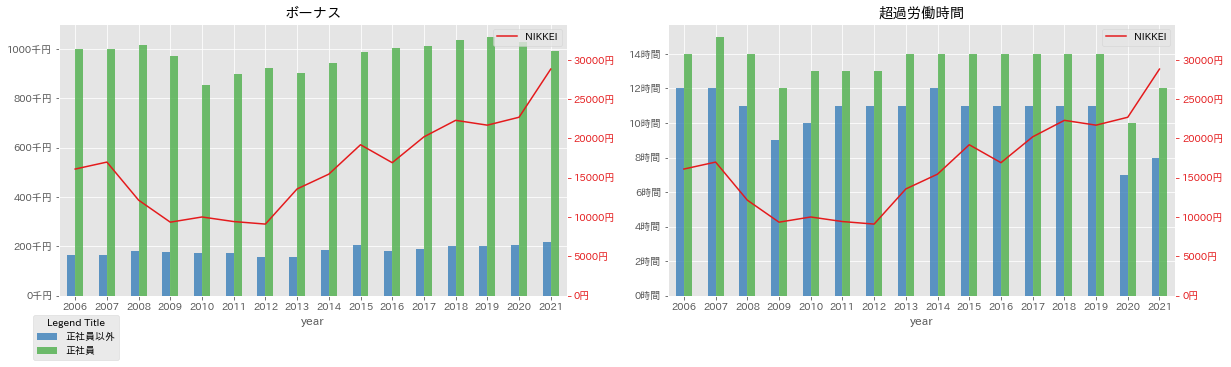

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharex=True, sharey=False)

bonus_pivot_df[agrecated_col].plot(
    kind="bar",
    rot=0,
    legend=False,
    ax=axes[0],
    alpha=0.8,
    color=(cm.Set1.colors[1], cm.Set1.colors[2]),
)
ax0_twin = axes[0].twinx()

df_stock.plot(ax=ax0_twin, label="日経225", color=cm.Set1.colors[0])

ax0_twin.set_ylim([0, df_stock["NIKKEI"].max() * 1.2])


axes[0].grid(True)
ax0_twin.grid(False)

ax0_twin.tick_params(axis="y", colors=cm.Set1.colors[0])

axes[0].yaxis.set_major_formatter(ticker.FormatStrFormatter("%d千円"))
ax0_twin.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d円"))

axes[0].set_axisbelow(True)
axes[0].set_title("ボーナス")


overtime_pivot_df[agrecated_col].plot(
    kind="bar",
    rot=0,
    legend=False,
    ax=axes[1],
    alpha=0.8,
    color=(cm.Set1.colors[1], cm.Set1.colors[2]),
)
ax1_twin = axes[1].twinx()

df_stock.plot(ax=ax1_twin, label="日経225", color=cm.Set1.colors[0])

ax1_twin.set_ylim([0, df_stock["NIKKEI"].max() * 1.2])


axes[1].grid(True)
ax1_twin.grid(False)

ax1_twin.tick_params(axis="y", colors=cm.Set1.colors[0])

axes[1].yaxis.set_major_formatter(ticker.FormatStrFormatter("%d時間"))
ax1_twin.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d円"))

axes[1].set_axisbelow(True)
axes[1].set_title("超過労働時間")


fig.legend(
    labels=["正社員以外", "正社員"],
    bbox_to_anchor=(0.1, 0.1),
    loc="upper left",
    borderaxespad=1,
    title="Legend Title",
)

plt.show()